In [9]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft as fft
import scipy.interpolate as interpolate
import IPython.display as ipd

In [2]:
plt.style.use('Solarize_Light2')
cmap = plt.cm.spring

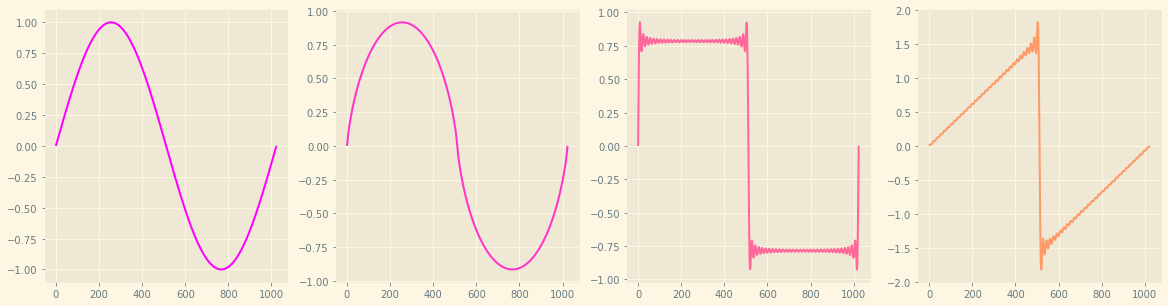

In [7]:
t = np.linspace(0, 2*np.pi, 1024)

# Create bandlimited waveforms

N = 64 # Number of partials
sinewave = np.sin(t)
triangle = sum([np.sin(x*t) * 1/x**2 * (-1)**(x + 1) for x in range(1, N) if x % 2 == 1])
square = sum([np.sin(x*t) * 1/x for x in range(1, N) if x % 2 == 1])
sawtooth = sum([np.sin(x*t) * 1/x * (-1)**(x + 1) for x in range(1, N)])

wavetable = np.array([sinewave, triangle, square, sawtooth])

fig, ax = plt.subplots(1, len(wavetable), figsize=(20, 5))

cmap = plt.cm.spring

for i, waveshape in enumerate(wavetable):
    # Plot each wave in the wavetable, which a color gradient
    ax[i].plot(waveshape, color=cmap(i/(len(wavetable) + 1)))
    
plt.show()

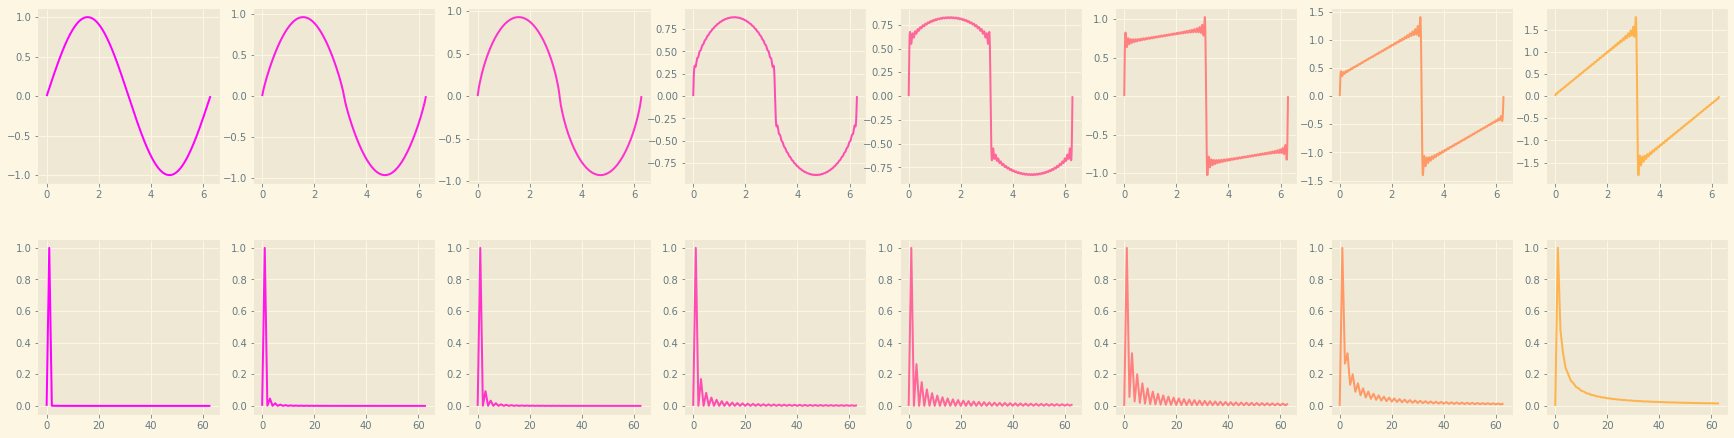

In [12]:
def read_table(wavetable, pos=0):
    """ Read signal from wavetable, with normalized input. This function
        demonstrates the basic technique, but is not totally functional
        since it can only read out the entire wavetable.
    """
    # Convert input in range 0.0 - 1.0 to wavetable position
    expanded_pos = pos * (len(wavetable) - 1)
    # Transpose table from shape [[table]] to [[samples]], or [[t10..t1n], [t20..t2n]], to [[s10..s1n], [s20..s2n]]
    table = wavetable.T
    t1 = int(expanded_pos)
    # Select the two samples at each index in the wavetable that will be interpolated to
    # create the output, based on the given wavetable position.
    samples = table[:, t1:t1+2]
    t2_amt = expanded_pos % 1
    t1_amt = 1 - t2_amt
    return [s1 * t1_amt + s2 * t2_amt for s1, s2 in samples]

def get_spectrum(sig):
    fcoeffs = fft.rfft(sig)
    Xmag = np.abs(fcoeffs) / len(sig) * 2
    return Xmag

fig, ax = plt.subplots(2, 8, figsize=(24, 6))


for i in range(8):
    sig = read_table(wavetable, i/7.1)
    spect = get_spectrum(sig)
    ax[0, i].plot(t, sig, color=cmap(i/10))
    ax[1, i].plot(spect[:64], color=cmap(i/10))
    
fig.tight_layout(pad=0.4,h_pad=4.0)
plt.show()


        
    

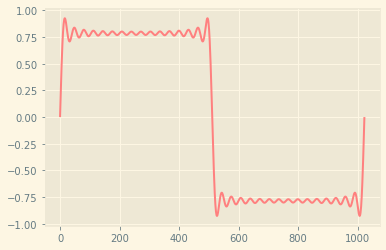

In [5]:
def fourier_series(partials, table_size=1024):
    t = np.linspace(0, 2*np.pi, 1024)
    sigs = [np.sin(freq * t) * amp for freq, amp in partials]
    return sum(sigs)

def square_partials(num_partials=32):
    return [(x, 1/x) for x in range(1, num_partials) if x % 2 == 1]

square = fourier_series(square_partials())

octaves_partials = [(x, 0.25) for x in [1, 2, 4, 8, 16]]
# plt.plot(fourier_series(octaves_partials))
plt.plot(square, color=cmap(0.5))

## Drawbars, from the Hammond Organ

[hammondtoday article with presets listing](http://www.hammondtoday.com/category/drawbar-settings/)

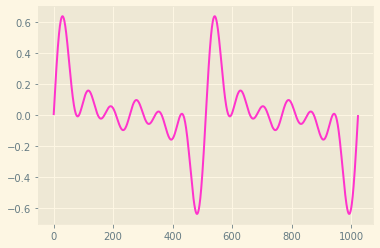

In [6]:
def drawbar_partials(levels="888000000"):
    freqs = [
        1, # 16',     Considered the sub-octave,
        3, # 5+1/3',  Perfect fifth above the fundamental
        2, # 8',      Considered the fundamental
        4, # 4',      Octave above the fundamental
        6, # 2+2/3'   Octave and a fifth above the fundamental
        8, # 2',      Two octaves above the fundamental
        10, # 1+3/5', Two octaves and a major third above the fundamental
        12, # 1+1/5', Two octaves and a fifth above the fundamental
        16, # 1',     Three octaves above the fundamental
    ]
    return zip(freqs, [float(amp)/8 * 0.25 for amp in list(levels.replace(" ", ""))])

drawbar_presets = {
    'jimmy': '88 8000 000',
    'dulciana': "00 4432 000",
    'french_horn': "00 8740 000",
    'full_swell': "32 7645 222",
    'stopped_flute': "00 5320 000",
    'cello': "00 4545 440",
    'clarinet': "00 7373 430",
    'full_great': "42 7866 244",
}

drawbars = fourier_series(drawbar_partials(levels=drawbar_presets['cello']))

plt.plot(drawbars, color=cmap(0.2))

sample_rate = 44100
signal = np.zeros(44100 * 5)

freq = 55

for i in range(44100 * 5):
    phase = i / sample_rate * freq
    table_index = (phase * 1024) % 1024
    signal[i] = drawbars[int(table_index)]

ipd.Audio(data=signal, rate=sample_rate, autoplay=False)

In [7]:
def organ_table(lev):
    return fourier_series(drawbar_partials(levels=lev))

def interpolate_linear(v1, v2, fraction):    
        v1_amt = 1 - fraction
        v2_amt = fraction
        return v1 * v1_amt + v2 * v2_amt
    
class TableReader:
    """ This is an object-oriented approach to sweeping through a wavetable
    """
    def __init__(self, wavetable):
        self.phase = 0
        self.num_tables = len(wavetable)
        self.table = wavetable.T
        self.current_table = 0
        
    # This is a debug method
    def update_current_table(self, index):
        self.current_table = index
        print(f'Reading from table {self.current_table}')
        
    def tick(self, ex_pos, freq):
        t1 = int(ex_pos)
        if t1 != self.current_table:
              self.update_current_table(t1)
        t2 = t1 + 1
        current_samples = self.table[int(self.phase) % len(self.table)]
        output = interpolate_linear(current_samples[t1], current_samples[t2], ex_pos % 1)
        self.phase += freq / 44100 * len(self.table)
        return output
    
drawbars_table = np.asarray([organ_table(levels) for levels in drawbar_presets.values()])
reader = TableReader(drawbars_table)
sample_rate = 44100
freq = 220

N = sample_rate * 5
output = np.zeros(N)
for i, position in enumerate(np.linspace(0.0, len(drawbars_table) - 1.001, N)):
    output[i] = reader.tick(position, freq)
    
ipd.Audio(data=output, rate=sample_rate, autoplay=False)

Reading from table 1
Reading from table 2
Reading from table 3
Reading from table 4
Reading from table 5
Reading from table 6


In [8]:
import itertools

N = sample_rate * 5
freq = 110

def read_table(wavetable, positions, freq):
    # This is a functional-based approach to reading a table. It's not as easy to debug
    # but very performant and terse, and it works much better with the interp1d function.
    # It's not really tickable though.
    tab = wavetable.T
    interp = interpolate.interp1d([0, 1], [0, len(wavetable) - 1.001])
    ps = interp(positions)
    phase_inc = freq / sample_rate * len(tab)
    def read_position(index, pos):
        t1 = int(pos)
        t2 = t1 + 1
        i = int(index * phase_inc % len(tab))
        current_samples = tab[i]
        sample = interpolate_linear(current_samples[t1], current_samples[t2], pos % 1)
        return sample
    return [read_position(i, pos) for i, pos in enumerate(ps)]

output = read_table(drawbars_table, np.linspace(0, 1, N), freq)
ipd.Audio(data=output, rate=sample_rate, autoplay=False)   